In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import glob
import random

### Load images -  get paths & images/arrays

#### Class

In [2]:

class Images():
    def __init__(self, folder):
        self.folder = folder
        self.data = '../raw_data'
        

    def get_images_from_folder(self):
        for root, dirs, files in os.walk(self.data):
            for d in dirs:
                if d == self.folder:
                    directory = os.path.join(root, d, 'img')
        files = os.listdir(directory)
        
        return [file for file in files]
    

    def get_images_as_arrays(self):
        for root, dirs, files in os.walk(self.data):
            for d in dirs:
                if d == self.folder:
                    directory = os.path.join(root, d, 'img')
        files = os.listdir(directory)
        images = []
        for f in files:
            dir_path = os.path.join(self.data, self.folder, 'img', f)
            absolute_path = os.path.abspath(dir_path)
            image_file = glob.glob(os.path.join(absolute_path))
            image = plt.imread("".join(image_file))
            images.append(image)
            
        return np.array(images)
    
    
    def display_image(self, nr=2):
        folder = self.folder.capitalize()
        img_list = self.get_images_from_folder()
        random_images = random.sample(img_list, k=min(nr, len(img_list)))

        num_rows = (len(random_images) + 1) // 2
        num_cols = min(2, len(random_images))

        if num_rows == 0 or num_cols == 0:
            return  # No images to display

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5*num_rows))

        if num_rows == 1:
            axes = np.array([axes])  # Convert to NumPy array
            axes = axes.reshape(1, num_cols)

        for i, r in enumerate(random_images):
            dir_path = "../raw_data/" + folder + "/img/"
            absolute_path = os.path.abspath(dir_path)
            image_file = glob.glob(os.path.join(absolute_path, r))
            image = plt.imread("".join(image_file))

            ax = axes[i // num_cols, i % num_cols]
            ax.imshow(image)
            ax.axis("off")

        plt.tight_layout()
        plt.show()
    

#### Create objects and visualize images

In [3]:
falciparum = Images('Falciparum')
malariae = Images('Malariae') 
ovale = Images('Ovale' ) 
vivax = Images('Vivax') 

In [4]:
print(f'falciparum: {len(falciparum.get_images_from_folder())} \
      malariae: {len(malariae.get_images_from_folder())} \
      ovale: {len(ovale.get_images_from_folder())} \
      vivax: {len(vivax.get_images_from_folder())}'
      )

falciparum: 104       malariae: 74       ovale: 58       vivax: 79


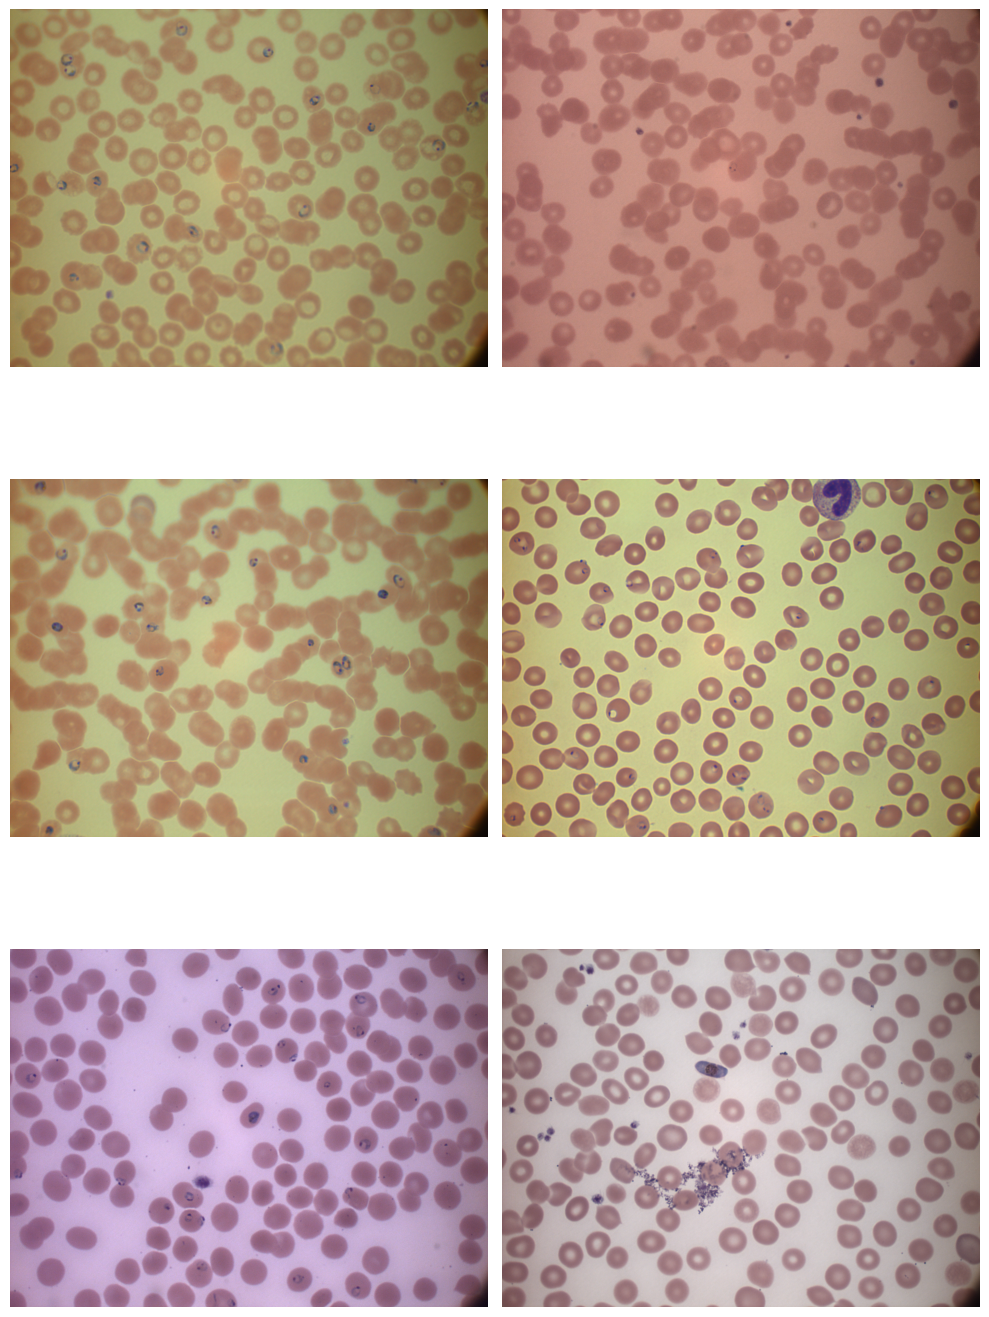

In [5]:
falciparum.display_image(6)

### Species Categories

In [6]:
def get_letter_combinations(text):
    if '0021_R_T' in text:
        text_group = 'R_T'
    else:
        last_dash = text.rfind('-')
        last_dot = text.rfind('.')
        text_group = text[last_dash +1 : last_dot]
    
    return text_group  

In [7]:
def create_df():

    combo = [falciparum.get_images_from_folder(), 
             malariae.get_images_from_folder(), 
             ovale.get_images_from_folder(),
             vivax.get_images_from_folder() ]
    
    dfs = []
    for species in combo:
        counts = {}
        for t in species:
            letter = get_letter_combinations(t)

            if letter in counts:
                counts[letter] += 1
            else:
                counts[letter] = 1
        dfs.append(counts)

    keys = ['falciparum', 'malariae', 'ovale', 'vivax']
    df = pd.DataFrame.from_records(dfs, index=keys) #df from list of dicts
    df = df.replace([np.inf, -np.inf, np.nan], 0) #replace inf and nan with 0
    df = df.astype(int) #convert to int
    df = df.transpose() 
    return df

df=create_df()
df

,falciparum,malariae,ovale,vivax
T,8,19,9,3
S,10,9,1,9
R,68,0,8,19
R_T,12,1,2,2
R_S,3,0,0,0
...,...,...,...,...
aug_0_4805,0,0,0,1
aug_0_9750,0,0,0,1
aug_0_7849,0,0,0,1
aug_0_6874,0,0,0,1


### Plotting

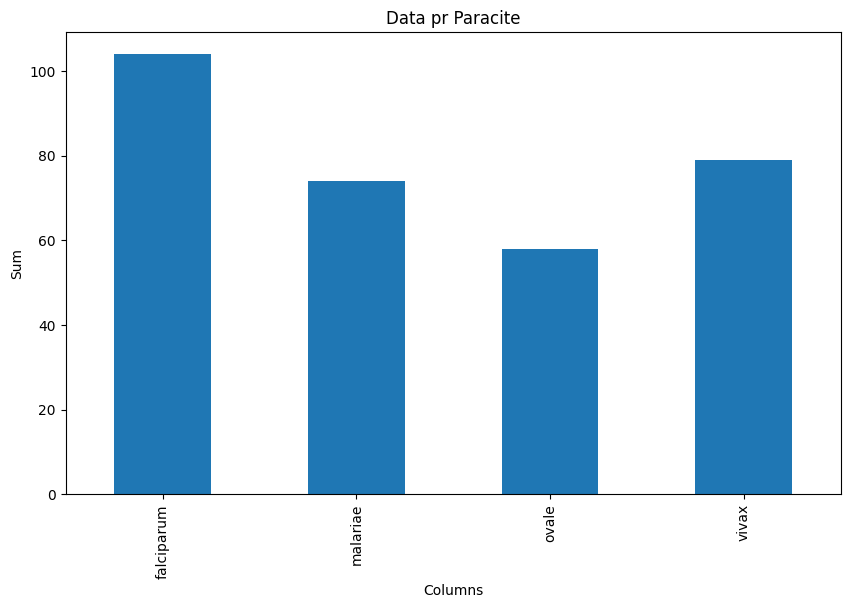

In [11]:
sums = df.sum()
sums.plot(kind='bar', figsize=(10, 6))
plt.title('Data pr Paracite')
plt.xlabel('Columns')
plt.ylabel('Sum')
plt.show()

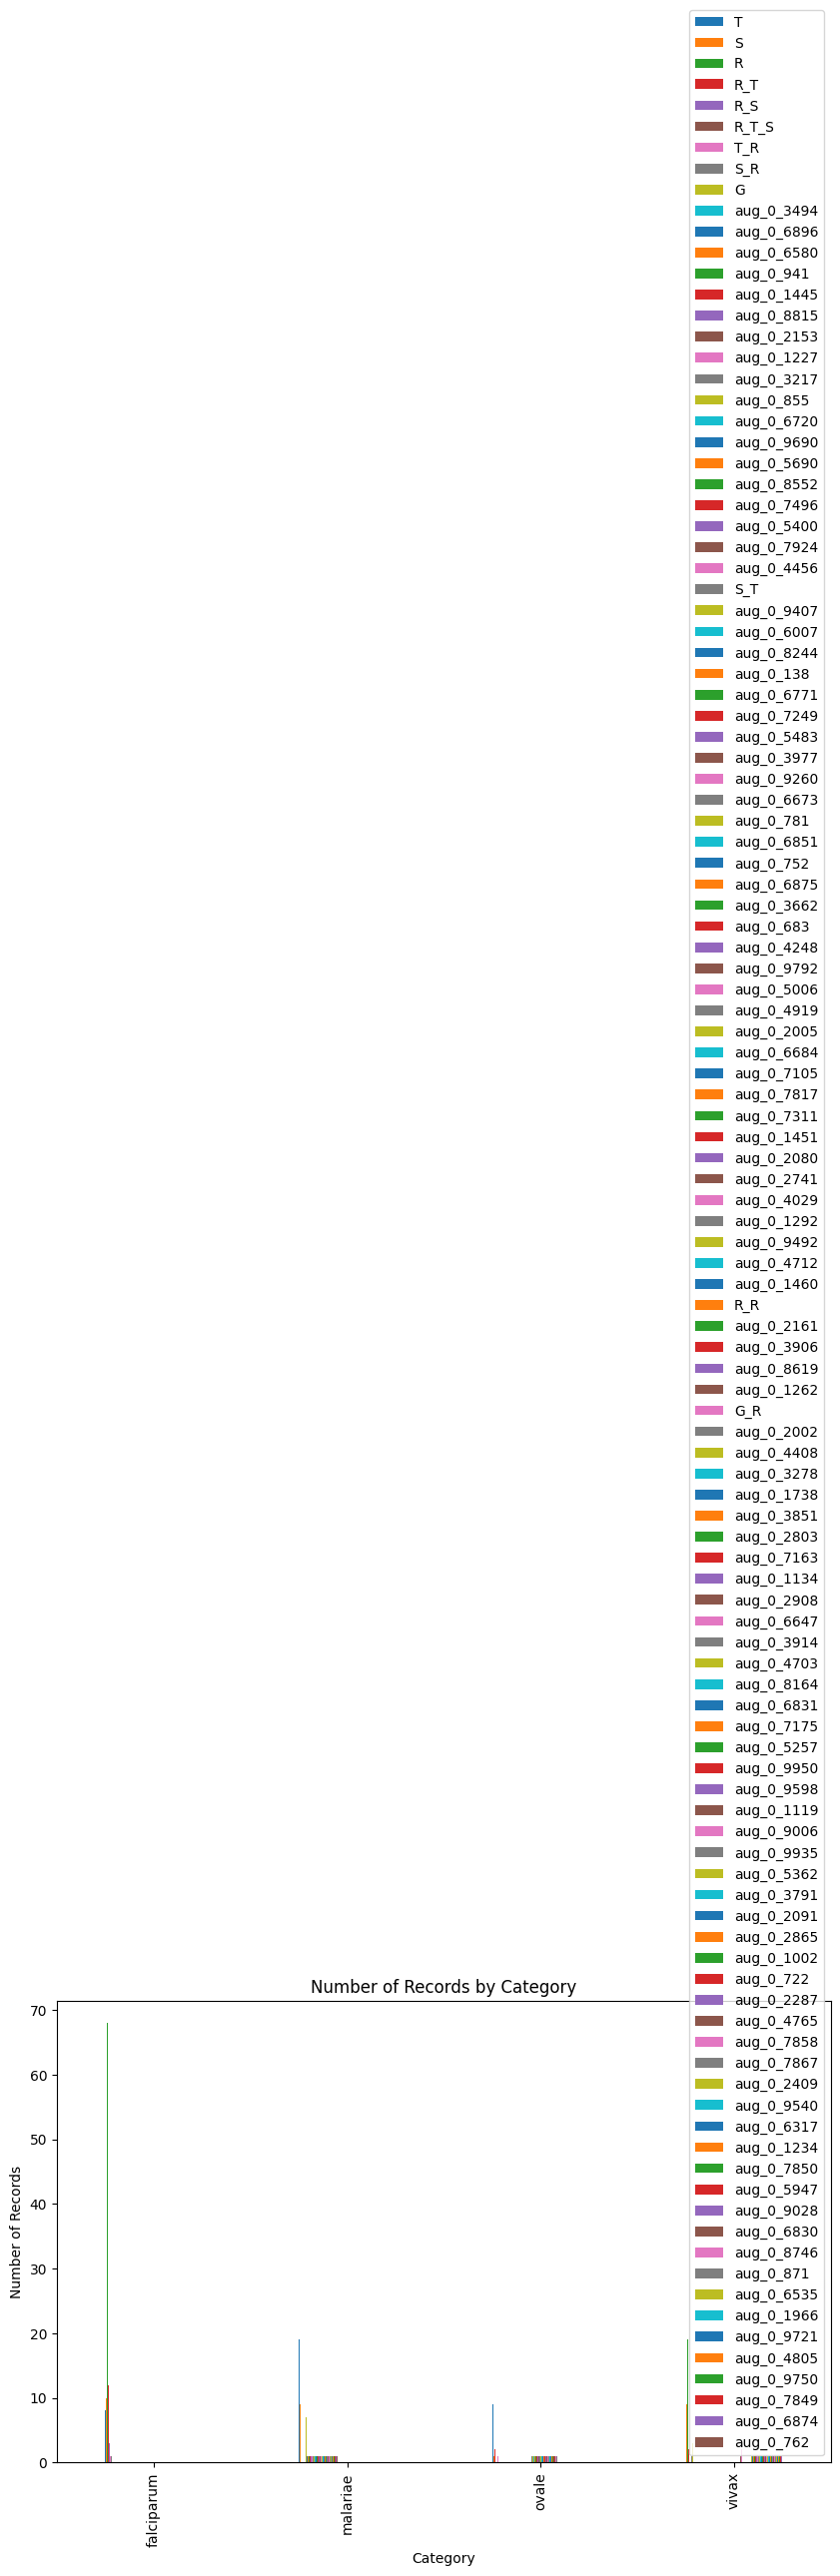

In [13]:
df.T.plot(kind='bar', figsize=(10, 6))
plt.title('Number of Records by Category')
plt.xlabel('Category')
plt.ylabel('Number of Records')
plt.show()

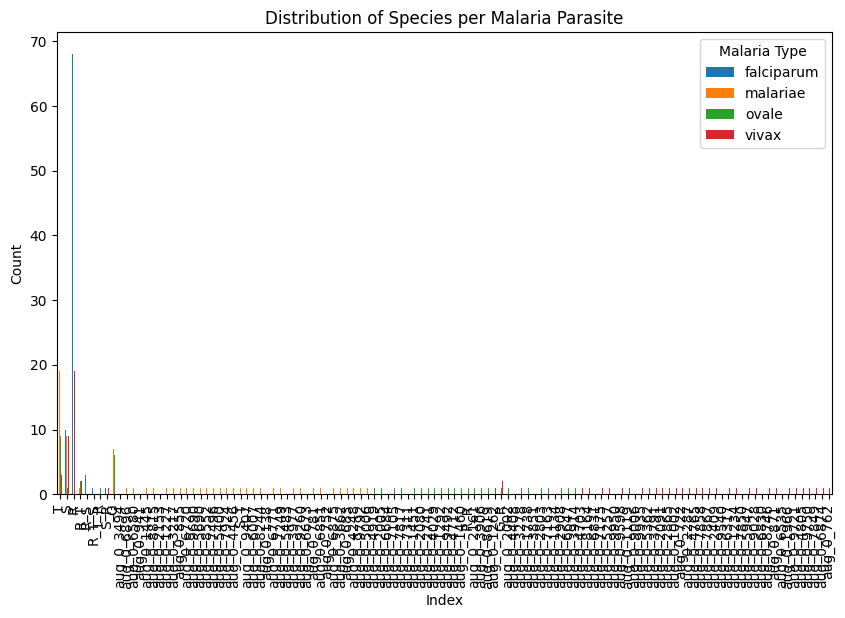

In [14]:
df.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Index')
plt.ylabel('Count')
plt.title('Distribution of Species per Malaria Parasite')
plt.legend(title='Malaria Type')
plt.show()

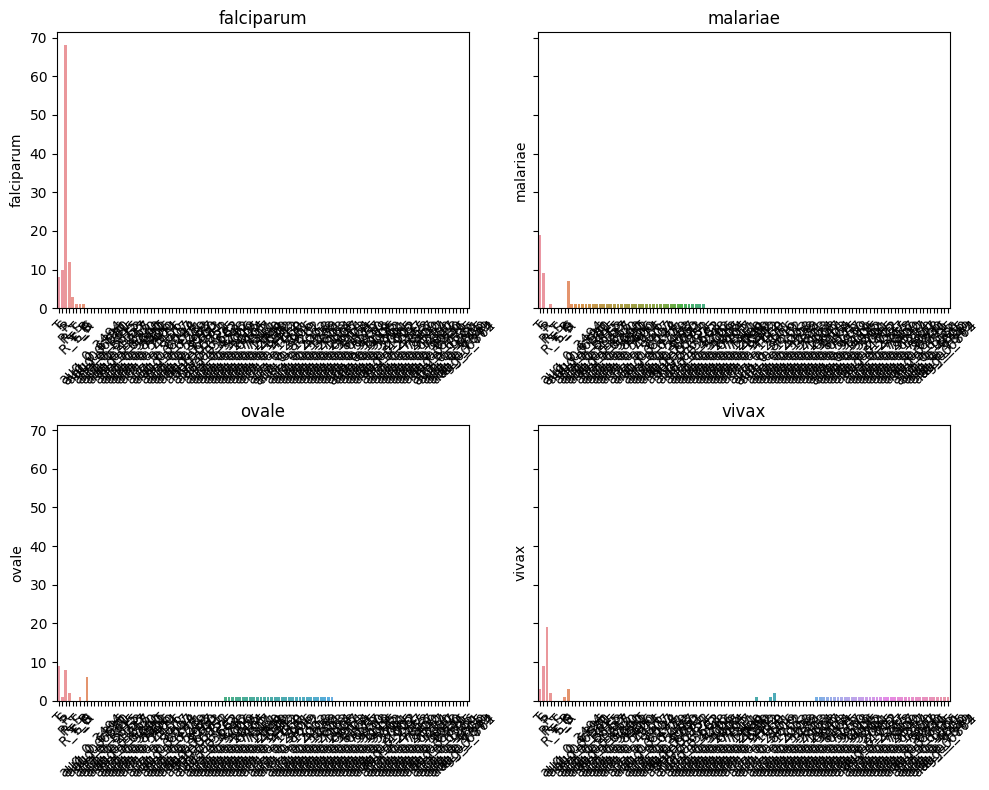

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
axes = axes.flatten()

for i, col in enumerate(['falciparum', 'malariae', 'ovale', 'vivax']):
    sns.barplot(data=df, x=df.index, y=col, ax=axes[i])

    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

###  Model


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, Flatten, MaxPooling2D, BatchNormalization

fal = falciparum.get_images_as_arrays()
mal = malariae.get_images_as_arrays()
ova = ovale.get_images_as_arrays()
viv = vivax.get_images_as_arrays()

2023-05-24 17:27:02.545643: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 17:27:02.659907: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-24 17:27:02.659922: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-24 17:27:02.678673: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-24 17:27:03.312927: W tensorflow/stream_executor/platform/de

In [17]:
X = np.concatenate((fal,mal,ova,viv), axis=0)
X.shape

(315, 1944, 2592, 3)

In [19]:
a= np.full((1,len(fal)), 1)
b= np.full((1,len(mal)), 2)
c= np.full((1,len(ova)), 3)
d= np.full((1,len(viv)), 4)

y = np.hstack((a,b,c,d))
y = y.reshape(315,1)

for value in y:
    value -= 1

In [21]:
from skimage.transform import resize
X_reshaped = np.zeros((315, 100, 100, 3), dtype=np.float32)

for i in range(X.shape[0]):
    X_reshaped[i] = resize(X[i], (100, 100, 3))

X_reshaped.shape

(315, 100, 100, 3)

In [22]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size =.3)
y_cat_train = to_categorical(y_train, num_classes=4)
y_cat_test = to_categorical(y_test, num_classes=4)

In [23]:
#Model
def create_model():

    model = Sequential()
    model.add(BatchNormalization(input_shape=(100,100,3)))
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['Accuracy'])
    
    return model

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

model = create_model()

es = EarlyStopping(
    patience = 10,
    verbose = 1,
    restore_best_weights = True)

history = model.fit(X_train, 
                    y_cat_train, 
                    validation_split = 0.3,
                    epochs = 50,
                    callbacks=[es],
                    verbose = 1) 
#Evaluate
Result = model.evaluate(X_test, y_cat_test)
Result

Epoch 1/50


2023-05-24 17:48:49.545144: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (100)
2023-05-24 17:48:49.545199: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (SLB-65Q77S2): /proc/driver/nvidia/version does not exist
2023-05-24 17:48:49.546053: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


5/5 [==============================] - 2s 225ms/step - loss: 2.0592 - Accuracy: 0.2532 - val_loss: 1.5954 - val_Accuracy: 0.1970
Epoch 2/50
5/5 [==============================] - 1s 167ms/step - loss: 1.2851 - Accuracy: 0.3247 - val_loss: 1.6058 - val_Accuracy: 0.3788
Epoch 3/50
5/5 [==============================] - 1s 170ms/step - loss: 1.1840 - Accuracy: 0.4351 - val_loss: 1.7569 - val_Accuracy: 0.5000
Epoch 4/50
5/5 [==============================] - 1s 167ms/step - loss: 1.0485 - Accuracy: 0.4935 - val_loss: 1.2645 - val_Accuracy: 0.5000
Epoch 5/50
5/5 [==============================] - 1s 165ms/step - loss: 1.1553 - Accuracy: 0.4545 - val_loss: 1.7103 - val_Accuracy: 0.4545
Epoch 6/50
5/5 [==============================] - 1s 164ms/step - loss: 1.0678 - Accuracy: 0.5065 - val_loss: 0.9965 - val_Accuracy: 0.5606
Epoch 7/50
5/5 [==============================] - 1s 169ms/step - loss: 1.0352 - Accuracy: 0.4935 - val_loss: 1.1102 - val_Accuracy: 0.5152
Epoch 8/50
5/5 [===============

[0.9330284595489502, 0.621052622795105]

In [25]:
def plot_history(history):
    plt.figure(figsize=(9,6))
    train = history.history['Accuracy']
    validate = history.history['val_Accuracy']
    epochs = range(1, len(train) + 1)
    
    plt.plot(epochs, train, 'b', label='Train ')
    plt.plot(epochs, validate, 'r', label='Validation')
    plt.title('Train and Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

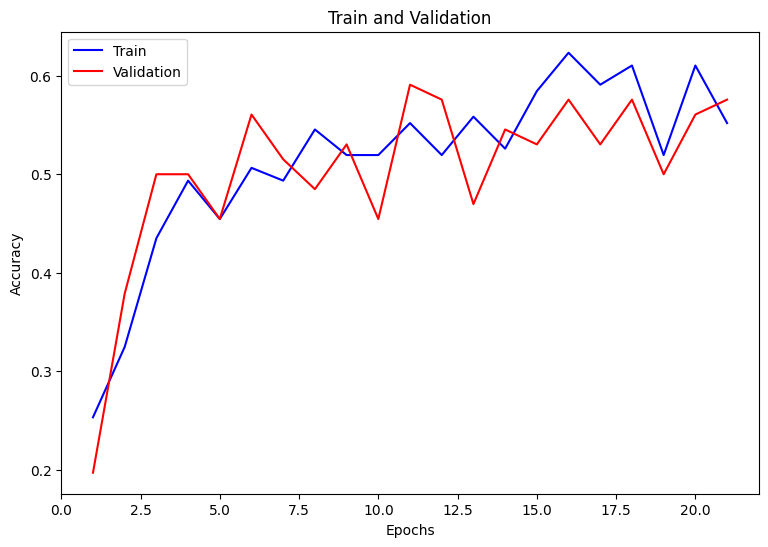

In [26]:
plot_history(history)

### Data Augmentation

#### Main

In [28]:
X_train.shape

(220, 100, 100, 3)

In [29]:
#Step1 - Split Train-VaL

random_indices = np.random.permutation(X_train.shape[0])
selected_indices = random_indices[:140]
X_tr = X_train[selected_indices]
y_tr = y_cat_train[selected_indices]
X_val = np.delete(X_train, selected_indices, axis=0)
y_val = np.delete(y_cat_train, selected_indices, axis=0)

X_tr.shape, y_tr.shape, X_val.shape, y_val.shape

((140, 100, 100, 3), (140, 4), (80, 100, 100, 3), (80, 4))

In [30]:
#Step2 - Define data generator and aug_var

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    brightness_range=(0,2),
    horizontal_flip = True
    )

data_aug = datagen.flow(X_tr, y_tr, batch_size=1, shuffle=False) #Create the augmented variables
data_val = datagen.flow(X_val, y_val, batch_size=1, shuffle=False)

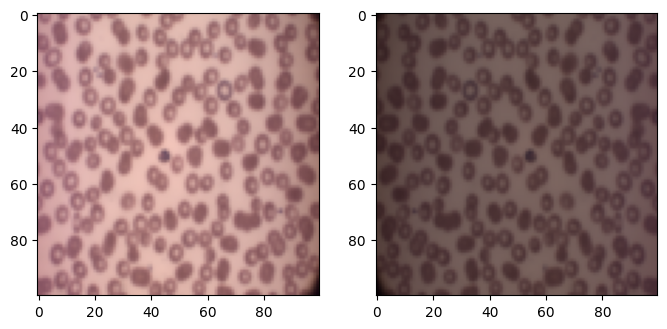

In [31]:
#Step3 - Visualize the augmentation

for i, (raw_image, augmented_element) in enumerate(zip(X_tr, data_aug)):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
    aug_var = augmented_element[0].squeeze()
    ax1.imshow(raw_image.astype(np.uint8))
    ax2.imshow(aug_var.astype(np.uint8))
    plt.show()
    
    if i > 10:
        break
    break

In [32]:
#Step4 - Fit 

es = EarlyStopping(patience = 10, verbose = 1, restore_best_weights = True)

model_aug = create_model()
history_aug = model_aug.fit(data_aug,
                        validation_data=data_val,
                        epochs = 50,
                        callbacks=[es],
                        verbose = 1) 

#res_aug = model_aug.evaluate(X_test, y_cat_test)
#res_aug

Epoch 1/50
140/140 [==============================] - 3s 21ms/step - loss: 1.6614 - Accuracy: 0.2786 - val_loss: 1.3889 - val_Accuracy: 0.3625
Epoch 2/50
140/140 [==============================] - 3s 20ms/step - loss: 1.3892 - Accuracy: 0.2929 - val_loss: 1.8040 - val_Accuracy: 0.2125
Epoch 3/50
140/140 [==============================] - 3s 20ms/step - loss: 1.3934 - Accuracy: 0.3357 - val_loss: 12.7100 - val_Accuracy: 0.1875
Epoch 4/50
140/140 [==============================] - 3s 20ms/step - loss: 1.4546 - Accuracy: 0.3643 - val_loss: 8.5212 - val_Accuracy: 0.2125
Epoch 5/50
140/140 [==============================] - 3s 20ms/step - loss: 1.4240 - Accuracy: 0.3714 - val_loss: 4.3944 - val_Accuracy: 0.2500
Epoch 6/50
140/140 [==============================] - 3s 20ms/step - loss: 1.2487 - Accuracy: 0.4429 - val_loss: 2.3107 - val_Accuracy: 0.2375
Epoch 7/50
140/140 [==============================] - 3s 20ms/step - loss: 1.1559 - Accuracy: 0.4286 - val_loss: 32.3225 - val_Accuracy: 0.20

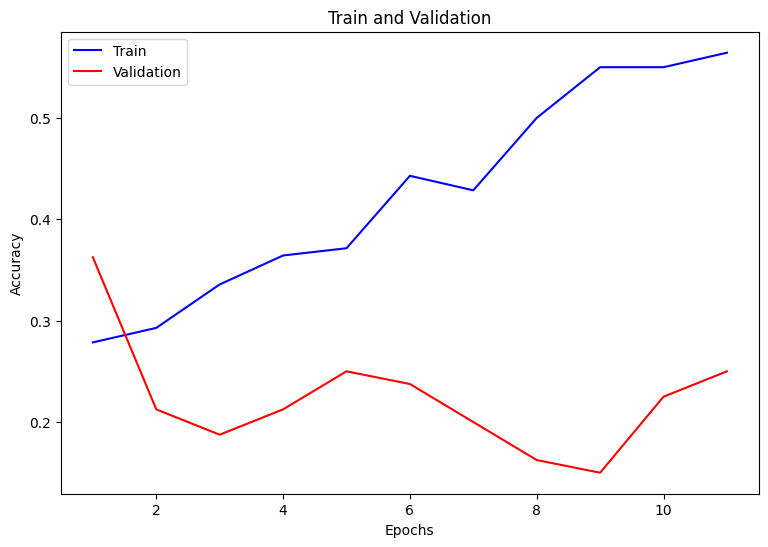

In [33]:
#Step5 - Visualize history

plot_history(history_aug)

### Y distribution

In [34]:
def plot_ydist(y, title='Category Distribution'):
    category_counts = np.sum(y, axis=0)
    total_samples = len(y)
    category_distribution = category_counts / total_samples * 100

    categories = ['Falciparum', 'Malariae', 'Ovale', 'Vivax']
    sns.set(style='whitegrid')
    plt.figure(figsize=(8, 6))

    ax = sns.barplot(x=categories, y=category_distribution, color='#1F77B4')
    ax.yaxis.grid(True, linestyle='--', alpha=0.5)
    ax.set_facecolor('#F5F8FC')

    plt.xlabel('Categories', fontweight='normal', color='brown')
    plt.ylabel('Percentage', fontweight='normal', color='brown')

    # Add percentage values inside the bars and count values on top of the bars
    for p, count, percentage in zip(ax.patches, category_counts, category_distribution):
        ax.annotate(f'{percentage:.2f}%', (p.get_x() + p.get_width() / 2, p.get_height() / 2),
                    ha='center', va='center', color='white')
        ax.annotate(str(int(count)), (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom')

    plt.xticks(fontstyle='italic')
    plt.title(title, fontweight='bold')
    plt.tight_layout()
    plt.show()

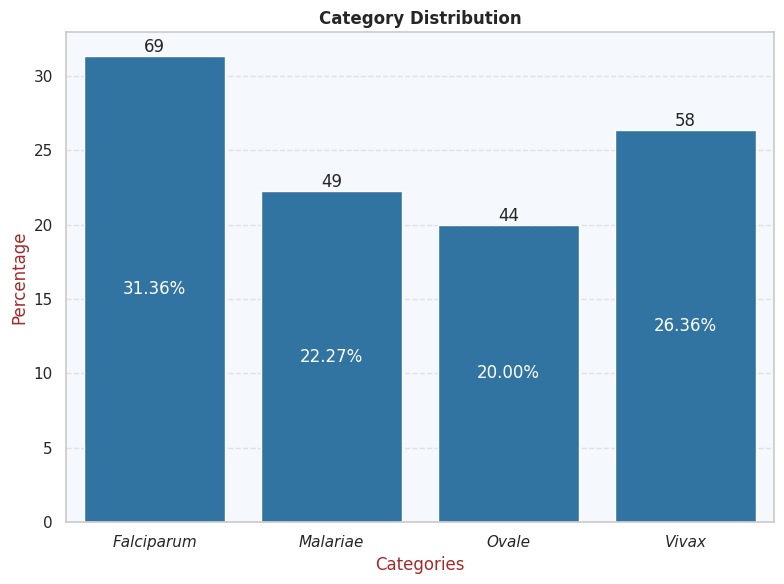

In [40]:
plot_ydist(y_cat_train)

### Class imbalance

In [ ]:
import numpy as np
from sklearn.utils import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
from sklearn.utils.class_weight import compute_class_weight


class_indices = np.array(class_indices)
class_weights = compute_class_weight('balanced', y=class_indices, classes=np.unique(class_indices) )
class_weights

In [ ]:
class_weight_mapping = dict(zip(np.unique(class_indices), class_weights))

In [ ]:
class_weight_mapping

In [ ]:
datagen = ImageDataGenerator(
    brightness_range=(0,2),
    horizontal_flip = True
    )

aug_img = datagen.flow(X_tr, y_tr, batch_size=1, shuffle=False, class_weight=class_weight_mapping) #Create the augmented variables
aug_img_val = datagen.flow(X_val, y_val, batch_size=1, shuffle=False, class_weight=class_weight_mapping)